# Lecture 19

## Downloading Data From Kaggle

You are likely going to be able to download the data for your kaggle competition by clicking the download button on data page. Note that since most of you are using WSL, and your browser is running in Windows, you should either copy the data into the virtual machine or read the Windows via the virtual machine. If the data file(s) are CSV, look at the contents of the file, as we have done in previous lectures and try to answer:
 
* Is the first row the column names?
* Comma separated?
* Number of rows
* Number of columns
* Size on disk    

For lab this Friday, you are required to download the data and load it up into a Pandas dataframe so we can take a look.

### Kaggle API

A better way to get your data from Kaggle is to use their API. You are not required to do this. But in case you would like to, follow instructions on how to install the [kaggle API](https://www.kaggle.com/docs/api) in your virtual machine. You will need to also setup your PATH environment variable, which can be tricky.
    
## Playing with Tabular Data

A recent [interesting paper](https://arxiv.org/pdf/2207.08815.pdf) compared the performance of Machine Learning algorithms on large number of tabular datasets, illustrating that Boosted Decision Trees are preferred ML Algorithm on tabular data. The datasets have been currated into a [kaggle competition](https://www.kaggle.com/competitions/bench-tab-v1), and we are going to take a look at them.

I've downloaded the datasets via kaggle API and unzip it to find the following:

In [75]:
!ls Train

334_361110     335_361101     336_361074     336_361088     337_361070
334_361111     335_361102     336_361076     336_361279     337_361273
334_361113     335_361103     336_361077     336_361280     337_361274
334_361282     335_361104     336_361078     336_361281     337_361275
334_361283     335_361287     336_361079     337_361055     337_361276
334_361285     335_361288     336_361080     337_361060     337_361277
334_361286     335_361289     336_361081     337_361061     337_361278
335_361093     335_361291     336_361082     337_361062     dict_suit.json
335_361094     335_361292     336_361083     337_361063     dict_task.json
335_361096     335_361293     336_361084     337_361065     submission.csv
335_361097     335_361294     336_361085     337_361066
335_361098     336_361072     336_361086     337_361068
335_361099     336_361073     336_361087     337_361069


In [2]:
!ls Train/334_361110

attribute_names.json       data_train.parquet
categorical_indicator.json target_train.parquet
data_test.parquet


Lets investigate the contents of some of these files:

In [3]:
!cat Train/dict_suit.json

{"334": [361110, 361111, 361113, 361282, 361283, 361285, 361286], "335": [361093, 361094, 361096, 361097, 361098, 361099, 361101, 361102, 361103, 361104, 361287, 361288, 361289, 361291, 361292, 361293, 361294], "336": [361072, 361073, 361074, 361076, 361077, 361078, 361079, 361080, 361081, 361082, 361083, 361084, 361085, 361086, 361087, 361088, 361279, 361280, 361281], "337": [361055, 361060, 361061, 361062, 361063, 361065, 361066, 361068, 361069, 361070, 361273, 361274, 361275, 361276, 361277, 361278]}

In [4]:
!cat Train/dict_task.json

{"336": {"features": "num", "target": "num"}, "337": {"features": "num", "target": "cat"}, "335": {"features": "num+cat", "target": "num"}, "334": {"features": "num+cat", "target": "cat"}}

In [5]:
import json
json.load(open("Train/dict_task.json","r"))

{'336': {'features': 'num', 'target': 'num'},
 '337': {'features': 'num', 'target': 'cat'},
 '335': {'features': 'num+cat', 'target': 'num'},
 '334': {'features': 'num+cat', 'target': 'cat'}}

In [6]:
datasets=json.load(open("Train/dict_suit.json","r"))

These json files seems to separate the datasets:

* 334: Classification with numerical and categorical inputs.
* 335: Regression with numerical and categorical inputs.
* 336: Regression with numerical inputs only.
* 337: Classification with numerical only.

Every dataset sits in it own directory, and contains the fillowing files:

In [77]:
!ls -lh Train/334_361110

total 2016
-rw-r--r--@ 1 afarbin  staff    87B Apr 15 11:59 attribute_names.json
-rw-r--r--@ 1 afarbin  staff    55B Apr 15 11:59 categorical_indicator.json
-rw-r--r--@ 1 afarbin  staff   361K Apr 15 11:59 data_test.parquet
-rw-r--r--@ 1 afarbin  staff   490K Apr 15 11:59 data_train.parquet
-rw-r--r--@ 1 afarbin  staff   142K Apr 15 11:59 target_train.parquet


Clearly the data is in parquet format, which luckily Pandas reads. And it is separated between train and test, where the target variable is for the training dataset is also provided in another parquet file. We'll check on this later.

Lets look at each `json` file to see if we can figure out what they contain:

In [8]:
!cat Train/334_361110/attribute_names.json

["date", "day", "period", "nswprice", "nswdemand", "vicprice", "vicdemand", "transfer"]

Looks like the field names. Probably redundant info, since it'll probably be in the parquet file too.

In [9]:
!cat Train/334_361110/categorical_indicator.json

[false, true, false, false, false, false, false, false]

Looks like a list indicating the the inputs are categorical or numerical. Seems like info that would be useful, so lets load it up into a python list: 

In [10]:
cat_list = json.load(open("Train/334_361110/categorical_indicator.json","r"))
cat_list

[False, True, False, False, False, False, False, False]

Basic counting:

In [11]:
num_cat, num_not_cat = sum(cat_list), len(cat_list)-sum(cat_list)
num_cat, num_not_cat

(1, 7)

## Check

Lets do some checks on all of these data sets.

First thing, lets see if any of these datasets have missing values. I'll work out a way to test this on one file first:

In [12]:
import pandas as pd
df = pd.read_parquet("Train/334_361110/data_train.parquet")

In [13]:
df.isnull()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
1027,False,False,False,False,False,False,False,False
28781,False,False,False,False,False,False,False,False
17825,False,False,False,False,False,False,False,False
33852,False,False,False,False,False,False,False,False
7502,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
6265,False,False,False,False,False,False,False,False
11284,False,False,False,False,False,False,False,False
38158,False,False,False,False,False,False,False,False
860,False,False,False,False,False,False,False,False


So this should test if there are any null values:

In [14]:
import numpy as np
np.any(df.isnull())

False

The shape of the `DataFrame` will tell me the number of datapoints and columns:

In [15]:
df.shape

(23084, 8)

Now lets look at target file:

In [16]:
df = pd.read_parquet("Train/334_361110/target_train.parquet")

In [17]:
df

,target
1027,0
28781,1
17825,0
33852,1
7502,0
...,...
6265,0
11284,0
38158,1
860,0


That's clearly a binary classification dataset. Lets look at a regression one:

In [18]:
df = pd.read_parquet("Train/336_361079/target_train.parquet")
df

,price
3032,10.614008
21981,12.385477
2094,10.768506
21574,9.615805
12850,10.292179
...,...
11964,10.322231
21575,10.518700
5390,10.566201
860,10.264687


Lets now look at every dataset and confirm some things. To determine if it's a classification or regression task, we can look at the target files:

In [19]:
!ls Train/*/target_train.parquet

Train/334_361110/target_train.parquet Train/336_361079/target_train.parquet
Train/334_361111/target_train.parquet Train/336_361080/target_train.parquet
Train/334_361113/target_train.parquet Train/336_361081/target_train.parquet
Train/334_361282/target_train.parquet Train/336_361082/target_train.parquet
Train/334_361283/target_train.parquet Train/336_361083/target_train.parquet
Train/334_361285/target_train.parquet Train/336_361084/target_train.parquet
Train/334_361286/target_train.parquet Train/336_361085/target_train.parquet
Train/335_361093/target_train.parquet Train/336_361086/target_train.parquet
Train/335_361094/target_train.parquet Train/336_361087/target_train.parquet
Train/335_361096/target_train.parquet Train/336_361088/target_train.parquet
Train/335_361097/target_train.parquet Train/336_361279/target_train.parquet
Train/335_361098/target_train.parquet Train/336_361280/target_train.parquet
Train/335_361099/target_train.parquet Train/336_361281/target_train.parquet
Train/335_36

Lets make a list of these filenames so we can open them up one by one:

In [20]:
import glob 
import numpy as np
target_files = glob.glob("Train/*/target_train.parquet")
target_files

['Train/335_361288/target_train.parquet',
 'Train/334_361283/target_train.parquet',
 'Train/334_361282/target_train.parquet',
 'Train/335_361289/target_train.parquet',
 'Train/334_361285/target_train.parquet',
 'Train/335_361287/target_train.parquet',
 'Train/336_361072/target_train.parquet',
 'Train/336_361086/target_train.parquet',
 'Train/337_361274/target_train.parquet',
 'Train/336_361081/target_train.parquet',
 'Train/337_361273/target_train.parquet',
 'Train/336_361088/target_train.parquet',
 'Train/337_361070/target_train.parquet',
 'Train/335_361102/target_train.parquet',
 'Train/336_361074/target_train.parquet',
 'Train/336_361080/target_train.parquet',
 'Train/336_361279/target_train.parquet',
 'Train/336_361087/target_train.parquet',
 'Train/336_361073/target_train.parquet',
 'Train/337_361275/target_train.parquet',
 'Train/335_361103/target_train.parquet',
 'Train/335_361104/target_train.parquet',
 'Train/337_361065/target_train.parquet',
 'Train/337_361062/target_train.pa

Now lets open them up one by one and take a look. I'm going to gather information about each dataset and save it into a dictionary which I'll present as a table, and use to easily get to specific datasets.

In [21]:
# Some lists and a dictionary to keep information 

classification_datasets = list()
regression_datasets = list()
binary_classification_datasets = list()
multiclass_classification_datasets = list()

dataset_summary = dict()

for target_file in target_files:
    # Load Dataset
    df = pd.read_parquet(target_file)

    # Extract the name from the file path
    dataset_name = target_file.split("/")[1]

    # Get number of training datapoints
    n_train = df.shape[0]
    
    # Check the target type is float
    a_value = df[df.columns[0]].to_numpy()[0]
    float_check = isinstance(a_value,np.float64)
    
    # Check number of unique targets
    n_unique = len(np.unique(df))
    
    # Open training set, check various things
    df_train = pd.read_parquet("train/"+dataset_name+"/data_train.parquet")
    if df_train.shape[0] != n_train:
        print ("Warning, dataset", dataset_name, "has mismatch of train/target rows.")
        
    n_features = df_train.shape[1]
    any_null = np.any(df_train.isnull())
    
    cat_list = json.load(open("Train/"+dataset_name+"/categorical_indicator.json","r"))
    num_cat, num_not_cat = sum(cat_list), len(cat_list)-sum(cat_list)
              
    # Lets see if we can deterimine the type of task based on the target:
    binary_classification = n_unique == 2
    multiclass_classification = n_unique < n_train/10 and not binary_classification
    regression = not binary_classification and not multiclass_classification

    if binary_classification:
        binary_classification_datasets.append(dataset_name)
        classification_datasets.append(dataset_name)
        
    if multiclass_classification:
        multiclass_classification_datasets.append(dataset_name)
        classification_datasets.append(dataset_name)
    
    if regression:
        regression_datasets.append(dataset_name)
        
    dataset_summary[dataset_name] = [dataset_name, binary_classification, 
                                     multiclass_classification, regression, n_train,
                                    any_null,n_features, num_cat, num_not_cat] 
        

In [22]:
print (len(binary_classification_datasets))
print (len(multiclass_classification_datasets))
print (len(regression_datasets))

23
18
18


In [23]:
dataset_summary

{'335_361288': ['335_361288', False, True, False, 2506, False, 8, 1, 7],
 '334_361283': ['334_361283', True, False, False, 7963, False, 21, 1, 20],
 '334_361282': ['334_361282', True, False, False, 34951, False, 31, 10, 21],
 '335_361289': ['335_361289', False, True, False, 31218, False, 4, 2, 2],
 '334_361285': ['334_361285', True, False, False, 67057, False, 32, 3, 29],
 '335_361287': ['335_361287', False, False, True, 5331, False, 255, 3, 252],
 '336_361072': ['336_361072', False, True, False, 4915, False, 21, 0, 21],
 '336_361086': ['336_361086', False, False, True, 97839, False, 3, 0, 3],
 '337_361274': ['337_361274', True, False, False, 34548, False, 54, 0, 54],
 '336_361081': ['336_361081', False, False, True, 6415, False, 8, 0, 8],
 '337_361273': ['337_361273', True, False, False, 42654, False, 7, 0, 7],
 '336_361088': ['336_361088', False, False, True, 12757, False, 79, 0, 79],
 '337_361070': ['337_361070', True, False, False, 4564, False, 20, 0, 20],
 '335_361102': ['335_3611

In [24]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(dataset_summary.values(), tablefmt='html', 
                               headers=["Name", "Binary", "Multi", "Regression", 
                                        "N Train", "Any Null", "N Features", "N Cat", "N non-Cat"])))

Name,Binary,Multi,Regression,N Train,Any Null,N Features,N Cat,N non-Cat
335_361288,False,True,False,2506,0,8,1,7
334_361283,True,False,False,7963,0,21,1,20
334_361282,True,False,False,34951,0,31,10,21
335_361289,False,True,False,31218,0,4,2,2
334_361285,True,False,False,67057,0,32,3,29
335_361287,False,False,True,5331,0,255,3,252
336_361072,False,True,False,4915,0,21,0,21
336_361086,False,False,True,97839,0,3,0,3
337_361274,True,False,False,34548,0,54,0,54
336_361081,False,False,True,6415,0,8,0,8


## Dataset loading

To make things easier, here's a quick function that will allow me to easily load the datasets. This will allow me to
easily switch between datasets.

In [25]:
def load_dataset(dataset_name):
    df_train = pd.read_parquet("Train/"+dataset_name+"/data_train.parquet")
    df_target = pd.read_parquet("Train/"+dataset_name+"/target_train.parquet")
    cat_list = json.load(open("Train/"+dataset_name+"/categorical_indicator.json","r"))
    attrib_list = json.load(open("Train/"+dataset_name+"/attribute_names.json","r"))
    
    return {"Training":df_train, "Target":df_target, "Categorical":cat_list, "Attributes": attrib_list}

In [26]:
# These are the classifications with categorical and numerical values
datasets["334"]

[361110, 361111, 361113, 361282, 361283, 361285, 361286]

In [27]:
# Lets select the binary classification datasets
list(filter(lambda t: t[1][1],dataset_summary.items()))

[('334_361283', ['334_361283', True, False, False, 7963, False, 21, 1, 20]),
 ('334_361282', ['334_361282', True, False, False, 34951, False, 31, 10, 21]),
 ('334_361285', ['334_361285', True, False, False, 67057, False, 32, 3, 29]),
 ('337_361274', ['337_361274', True, False, False, 34548, False, 54, 0, 54]),
 ('337_361273', ['337_361273', True, False, False, 42654, False, 7, 0, 7]),
 ('337_361070', ['337_361070', True, False, False, 4564, False, 20, 0, 20]),
 ('337_361275', ['337_361275', True, False, False, 7963, False, 20, 0, 20]),
 ('337_361065', ['337_361065', True, False, False, 8025, False, 10, 0, 10]),
 ('337_361062', ['337_361062', True, False, False, 6049, False, 26, 0, 26]),
 ('334_361113', ['334_361113', True, False, False, 254208, False, 54, 44, 10]),
 ('337_361055', ['337_361055', True, False, False, 10028, False, 10, 0, 10]),
 ('337_361063', ['337_361063', True, False, False, 8092, False, 16, 0, 16]),
 ('334_361286', ['334_361286', True, False, False, 2979, False, 11, 8

In [28]:
## Why did I do this? I had it already!

binary_classification = list(map(lambda x: x[0],filter(lambda t: t[1][1],dataset_summary.items())))
multi_classification = list(map(lambda x: x[0],filter(lambda t: t[1][2],dataset_summary.items())))
regression = list(map(lambda x: x[0],filter(lambda t: t[1][3],dataset_summary.items())))

Lets load a dataset and take a look:

In [127]:
d1=load_dataset(binary_classification[0])

In [30]:
d1["Training"]

,x1,x2,x5,x6,x7,x8,x9,x10,x11,x12,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
7249,30000.0,1,22,0.0,0.0,0.0,2.0,0.0,0.0,27444.0,...,29886.0,28392.0,22612.0,22750.0,2000.0,1800.0,0.0,1000.0,1000.0,0.0
8814,50000.0,0,41,4.0,3.0,2.0,0.0,0.0,-1.0,52955.0,...,50307.0,27707.0,28479.0,28979.0,0.0,0.0,0.0,974.0,31100.0,1200.0
2083,310000.0,1,42,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-606.0,...,19950.0,79227.0,20097.0,25594.0,45484.0,20033.0,79520.0,94.0,25910.0,10933.0
7735,150000.0,0,56,2.0,0.0,0.0,0.0,0.0,0.0,116928.0,...,43045.0,40813.0,42164.0,43465.0,5006.0,3000.0,1452.0,5000.0,5000.0,2000.0
10646,120000.0,1,33,0.0,0.0,0.0,-1.0,-1.0,0.0,35563.0,...,19747.0,1201.0,2333.0,2250.0,1426.0,6400.0,1500.0,2700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,50000.0,1,50,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,50000.0,1,34,0.0,0.0,-1.0,-1.0,-1.0,-1.0,2435.0,...,197.0,2995.0,19515.0,0.0,0.0,197.0,2995.0,19515.0,0.0,3734.0
5390,10000.0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,9457.0,...,7335.0,9025.0,7886.0,8382.0,1107.0,1310.0,2000.0,269.0,1000.0,1100.0
860,50000.0,1,23,0.0,0.0,0.0,0.0,-1.0,0.0,48482.0,...,11151.0,-2897.0,48211.0,48154.0,2500.0,3002.0,1500.0,52000.0,1900.0,1800.0


In [31]:
d1["Training"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7963 entries, 7249 to 7270
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x1      7963 non-null   float64 
 1   x2      7963 non-null   category
 2   x5      7963 non-null   uint8   
 3   x6      7963 non-null   float64 
 4   x7      7963 non-null   float64 
 5   x8      7963 non-null   float64 
 6   x9      7963 non-null   float64 
 7   x10     7963 non-null   float64 
 8   x11     7963 non-null   float64 
 9   x12     7963 non-null   float64 
 10  x13     7963 non-null   float64 
 11  x14     7963 non-null   float64 
 12  x15     7963 non-null   float64 
 13  x16     7963 non-null   float64 
 14  x17     7963 non-null   float64 
 15  x18     7963 non-null   float64 
 16  x19     7963 non-null   float64 
 17  x20     7963 non-null   float64 
 18  x21     7963 non-null   float64 
 19  x22     7963 non-null   float64 
 20  x23     7963 non-null   float64 
dtypes: category

In [32]:
list(zip(d1["Attributes"],d1["Categorical"]))

[('x1', False),
 ('x2', True),
 ('x5', False),
 ('x6', False),
 ('x7', False),
 ('x8', False),
 ('x9', False),
 ('x10', False),
 ('x11', False),
 ('x12', False),
 ('x13', False),
 ('x14', False),
 ('x15', False),
 ('x16', False),
 ('x17', False),
 ('x18', False),
 ('x19', False),
 ('x20', False),
 ('x21', False),
 ('x22', False),
 ('x23', False)]

In [33]:
d1["Training"].columns

Index(['x1', 'x2', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13',
       'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23'],
      dtype='object')

## First Visualization

For binary classification tasks, we want compare histograms each feature for the two categories.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([3247., 1515., 1411.,  746.,  520.,  269.,  225.,   14.,    7.,
           9.]),
 array([ 10000.,  84000., 158000., 232000., 306000., 380000., 454000.,
        528000., 602000., 676000., 750000.]),
 <BarContainer object of 10 artists>)

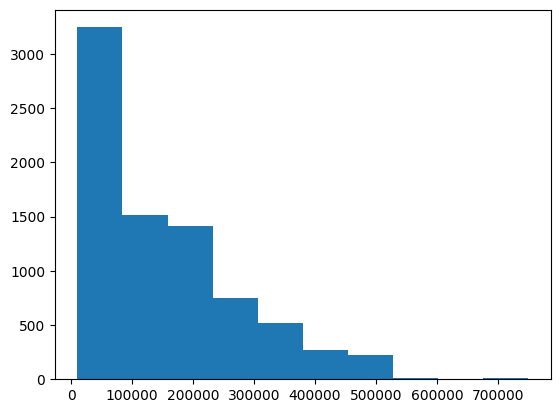

In [35]:
plt.hist(d1["Training"][d1["Training"].columns[0]])

In [36]:
d1["Training"][(d1["Target"]==0).to_numpy()]

,x1,x2,x5,x6,x7,x8,x9,x10,x11,x12,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
2083,310000.0,1,42,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-606.0,...,19950.0,79227.0,20097.0,25594.0,45484.0,20033.0,79520.0,94.0,25910.0,10933.0
5147,20000.0,0,34,1.0,2.0,0.0,0.0,0.0,0.0,15095.0,...,12607.0,16430.0,19230.0,0.0,0.0,6000.0,5000.0,3000.0,0.0,0.0
675,20000.0,1,32,0.0,0.0,0.0,2.0,0.0,0.0,18539.0,...,21274.0,20109.0,19976.0,20143.0,1400.0,3300.0,0.0,1000.0,1000.0,1000.0
2545,130000.0,1,27,0.0,0.0,0.0,0.0,0.0,0.0,107599.0,...,112635.0,114472.0,117556.0,116090.0,4030.0,4600.0,4200.0,5000.0,5000.0,21932.0
3999,80000.0,1,26,0.0,0.0,0.0,0.0,0.0,0.0,78513.0,...,80131.0,75920.0,75421.0,73991.0,3000.0,5000.0,3500.0,8000.0,3000.0,3200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,110000.0,1,46,0.0,0.0,0.0,0.0,0.0,0.0,45846.0,...,48325.0,0.0,49461.0,48438.0,2000.0,2000.0,2000.0,0.0,2000.0,2000.0
5734,280000.0,1,31,1.0,-2.0,-2.0,-2.0,-1.0,-1.0,0.0,...,0.0,0.0,5360.0,251.0,0.0,0.0,0.0,5360.0,251.0,5360.0
5191,50000.0,1,34,0.0,0.0,-1.0,-1.0,-1.0,-1.0,2435.0,...,197.0,2995.0,19515.0,0.0,0.0,197.0,2995.0,19515.0,0.0,3734.0
5390,10000.0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,9457.0,...,7335.0,9025.0,7886.0,8382.0,1107.0,1310.0,2000.0,269.0,1000.0,1100.0


Here's a function that will compare the probability distributions of each feature, separated by the 2 populations:

In [82]:
import math
import scipy

def compare_features_binary(d,logscale=False):
    # Divide the data into separate dfs for the two categories
    
    df_0=d["Training"][(d["Target"]==0).to_numpy()]
    df_1=d["Training"][(d["Target"]==1).to_numpy()]
    
    print("Number of catogory 0:",df_0.shape[0])
    print("Number of catogory 1:",df_1.shape[0])
    
    # Make a grid of plots
    N_Features = d["Training"].shape[1]
    N_X= math.ceil(math.sqrt(N_Features))
    N_Y= math.floor(math.sqrt(N_Features))
    if N_X*N_Y<N_Features:
        N_Y+=1

    print("Found",N_Features,"features. Creating grid of",N_X,"by",N_Y)
    
    # Histogram Features
    plt.figure(figsize=(50,50))

    for i,column in enumerate(df_0.columns):
        KS_test=scipy.stats.kstest(df_0[column],df_1[column]).statistic
        KS_test_str="{KS:.3f}".format(KS=KS_test)
        print(column,"KS Distribution Similarity Test:", KS_test_str)
        
        plt.subplot(N_X,N_Y,i+1)
        plt.title(KS_test_str)
        if logscale:
            plt.yscale("log")
        plt.hist(df_0[column],bins=100, histtype="step", color="red",label="0",density=1, stacked=True)
        plt.hist(df_1[column],bins=100, histtype="step", color="blue",label="1",density=1, stacked=True)
        plt.legend()
        plt.xlabel(column)
        
    plt.show()

Number of catogory 0: 3977
Number of catogory 1: 3986
Found 21 features. Creating grid of 5 by 5
x1 KS Distribution Similarity Test: 0.184
x2 KS Distribution Similarity Test: 0.051
x5 KS Distribution Similarity Test: 0.036
x6 KS Distribution Similarity Test: 0.366
x7 KS Distribution Similarity Test: 0.290
x8 KS Distribution Similarity Test: 0.256
x9 KS Distribution Similarity Test: 0.220
x10 KS Distribution Similarity Test: 0.187
x11 KS Distribution Similarity Test: 0.175
x12 KS Distribution Similarity Test: 0.046
x13 KS Distribution Similarity Test: 0.036
x14 KS Distribution Similarity Test: 0.027
x15 KS Distribution Similarity Test: 0.029
x16 KS Distribution Similarity Test: 0.028
x17 KS Distribution Similarity Test: 0.034
x18 KS Distribution Similarity Test: 0.150
x19 KS Distribution Similarity Test: 0.145
x20 KS Distribution Similarity Test: 0.145
x21 KS Distribution Similarity Test: 0.129
x22 KS Distribution Similarity Test: 0.119
x23 KS Distribution Similarity Test: 0.125


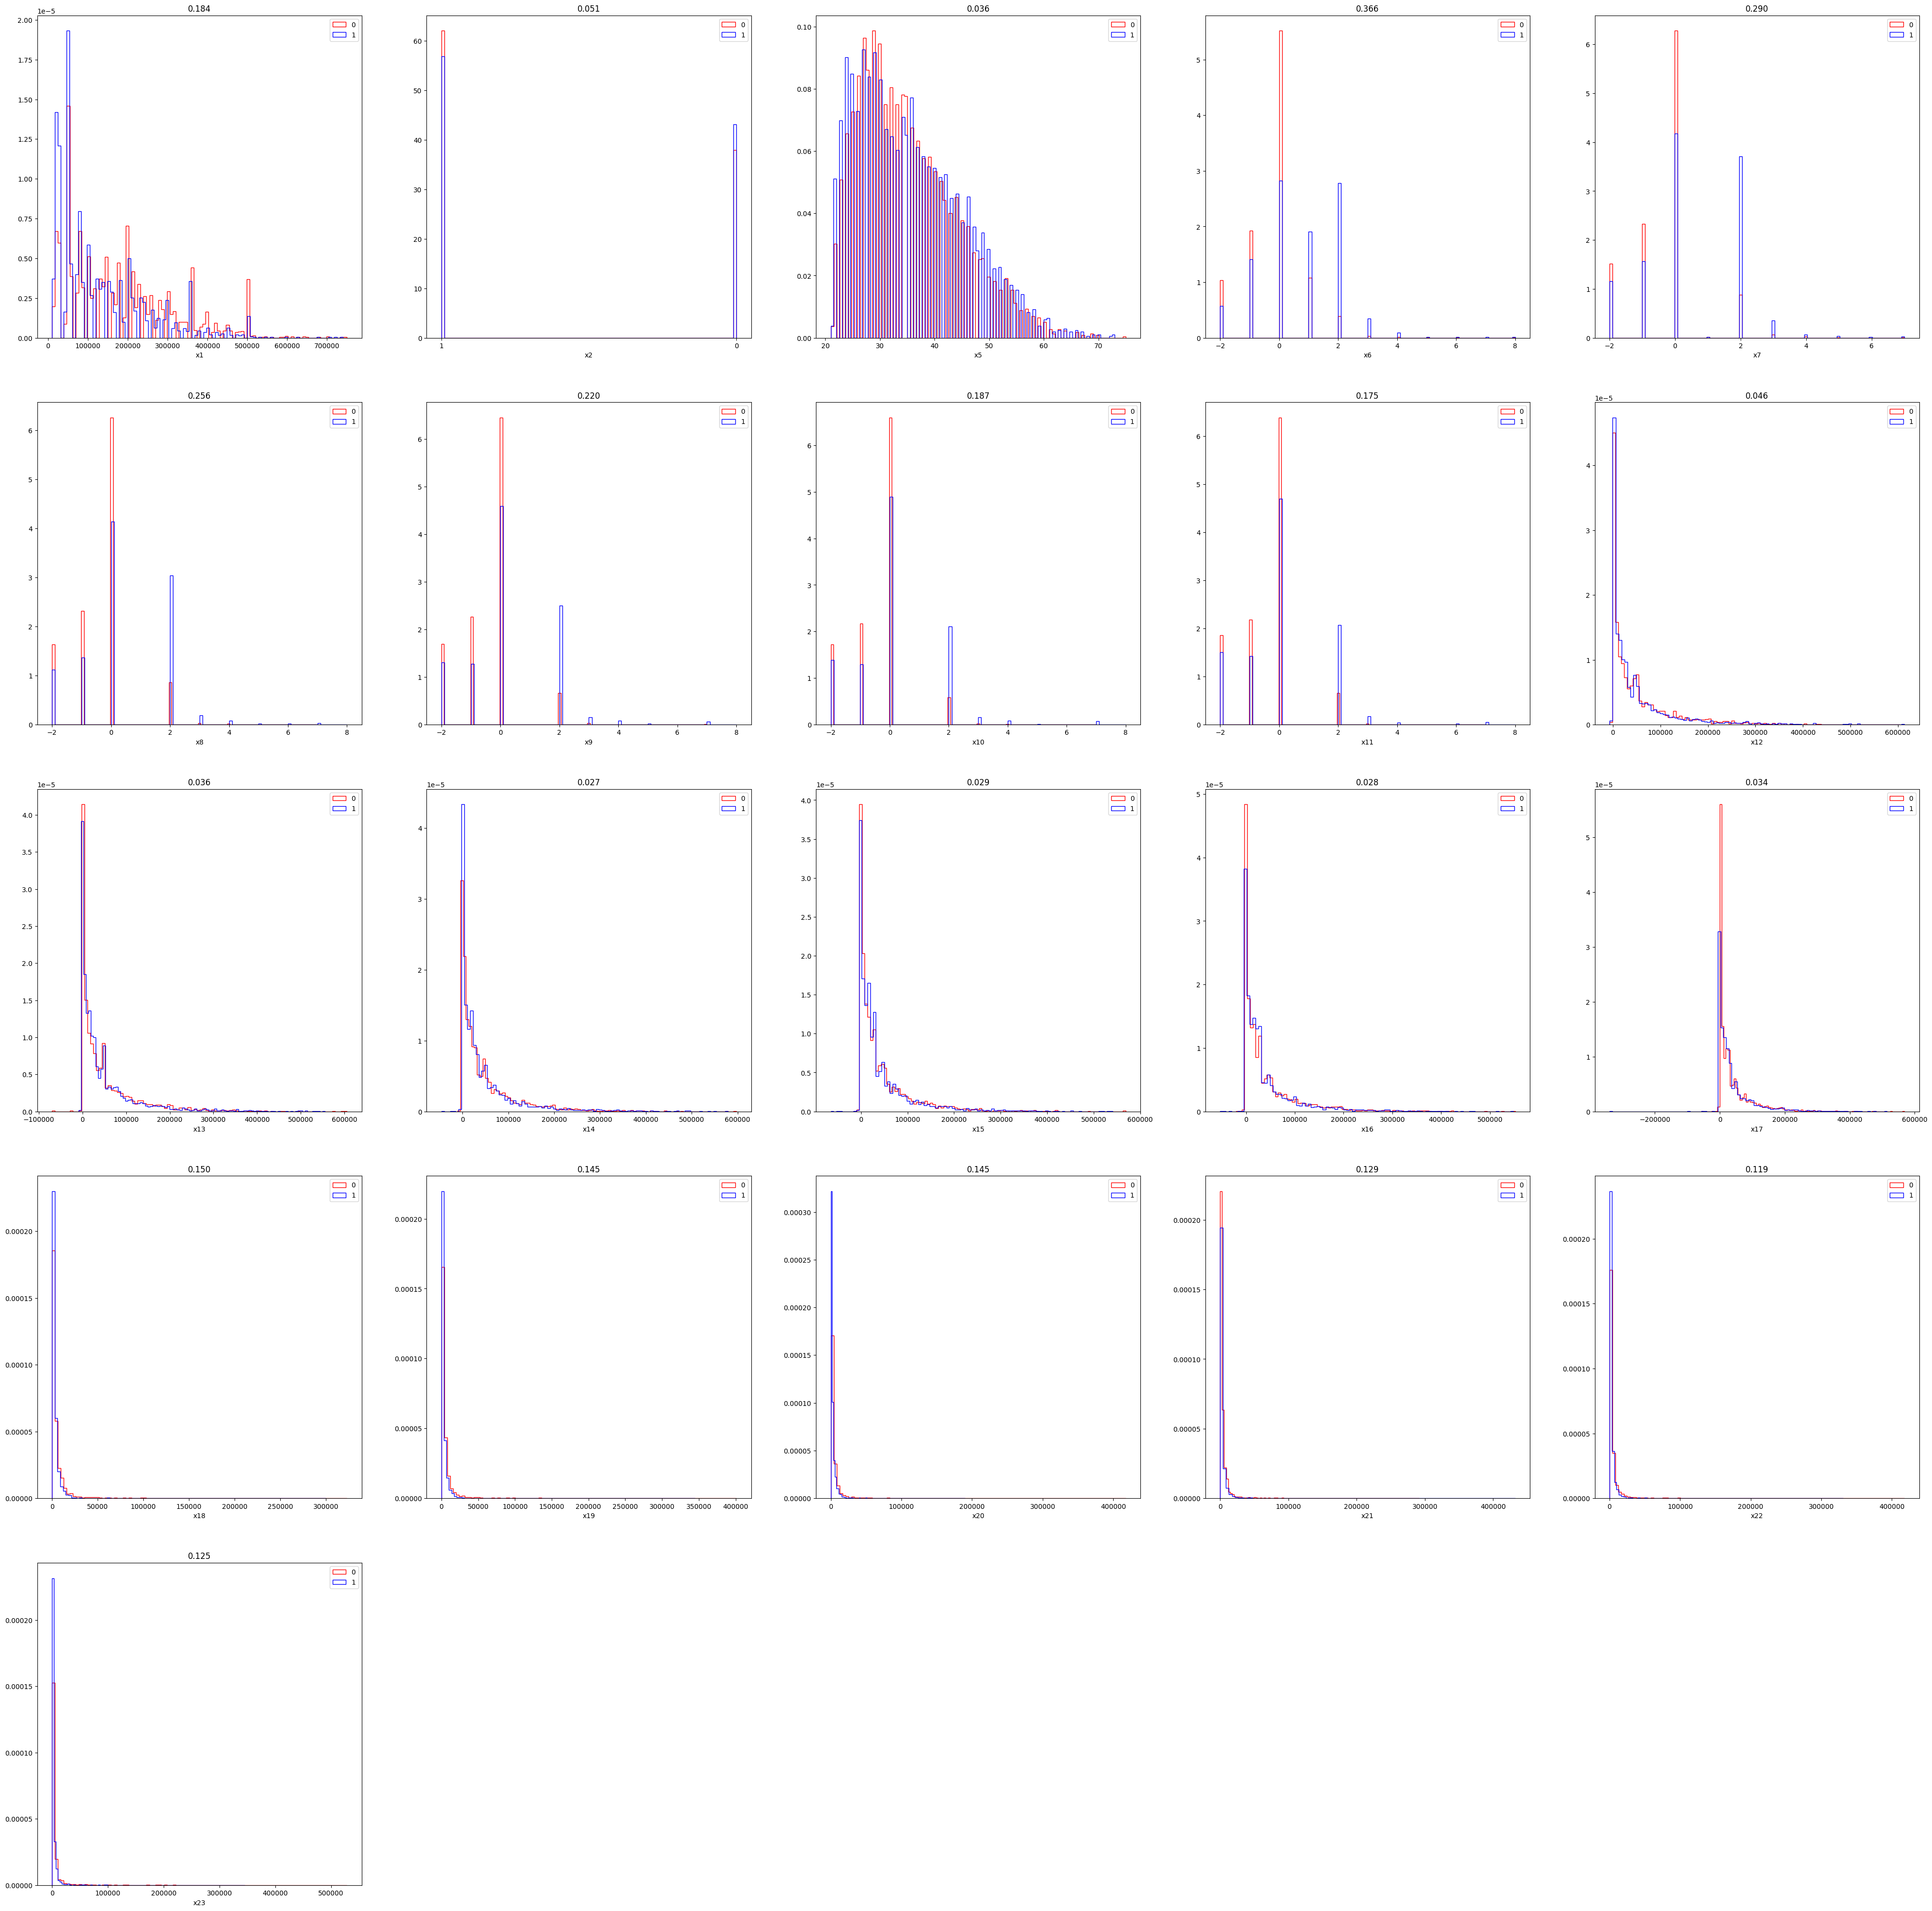

In [83]:
compare_features_binary(d1)

Number of catogory 0: 33447
Number of catogory 1: 33610
Found 32 features. Creating grid of 6 by 6
Vehicle_Reference_df_res KS Distribution Similarity Test: 0.039
Vehicle_Type KS Distribution Similarity Test: 0.131
Vehicle_Manoeuvre KS Distribution Similarity Test: 0.075
Vehicle_Location-Restricted_Lane KS Distribution Similarity Test: 0.004
Hit_Object_in_Carriageway KS Distribution Similarity Test: 0.006
Hit_Object_off_Carriageway KS Distribution Similarity Test: 0.009
Was_Vehicle_Left_Hand_Drive? KS Distribution Similarity Test: 0.001
Age_of_Driver KS Distribution Similarity Test: 0.034
Age_Band_of_Driver KS Distribution Similarity Test: 0.034
Engine_Capacity_(CC) KS Distribution Similarity Test: 0.230
Propulsion_Code KS Distribution Similarity Test: 0.182
Age_of_Vehicle KS Distribution Similarity Test: 0.030
Location_Easting_OSGR KS Distribution Similarity Test: 0.044
Location_Northing_OSGR KS Distribution Similarity Test: 0.038
Longitude KS Distribution Similarity Test: 0.042
Latit

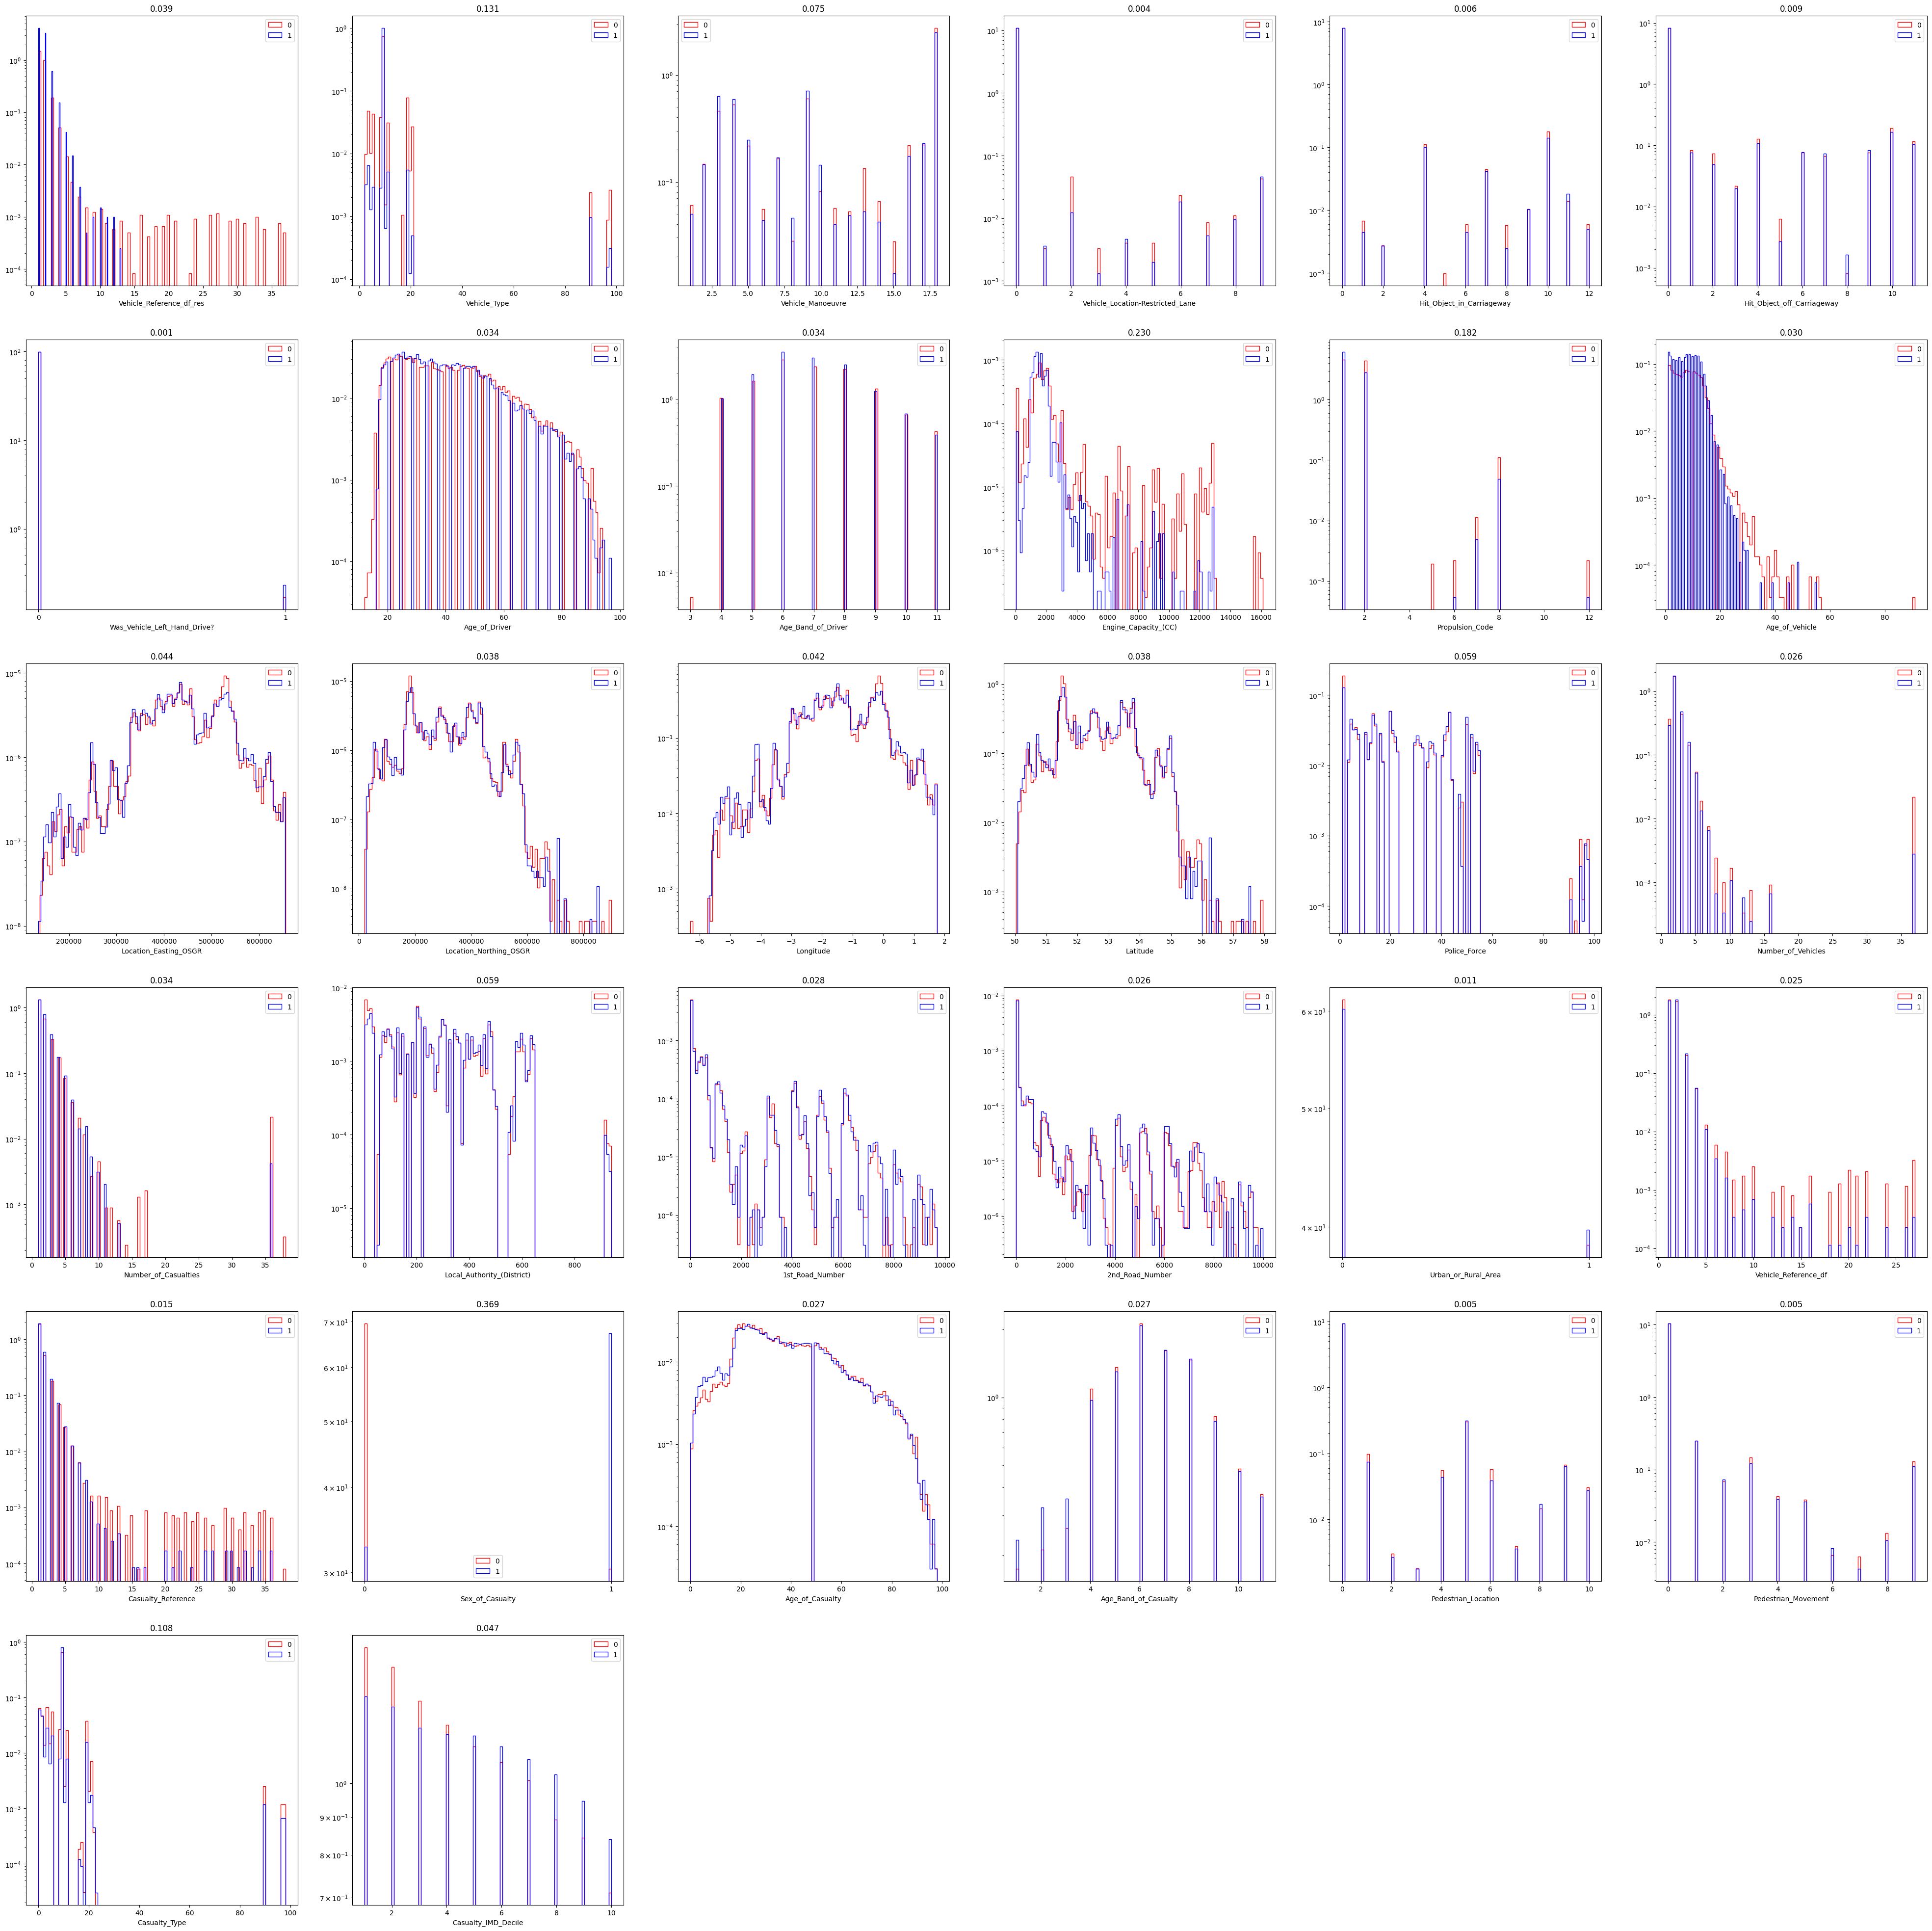

In [107]:
compare_features_binary(load_dataset(binary_classification[2]),True)

## Correlations

Its often important to assess of features are correlated or not. For example, if 2 features are 100% correlated, then only one is needed for input to ML algorithms. The correlation information, coupled with the KS test results, can give us a sense of what features would be useful. 

Also, even if the distribution of features look the same for different populations, it is possible that the correlations are different between the populations, allowing discrimination between them. That means that looking at the correlations for different populations may give us additional insight into the dataset.

In [40]:
c_df = d1["Training"].corr()
c_df

/var/folders/zy/0rgyywr10tq2p0l5lkdf14v80000gq/T/ipykernel_39613/2033704896.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c_df = d1["Training"].corr()


,x1,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
x1,1.000000,0.149513,-0.284907,-0.324708,-0.316446,-0.296943,-0.278341,-0.258535,0.301183,0.291240,0.296278,0.296822,0.300129,0.294138,0.210170,0.222058,0.214939,0.206587,0.227945,0.216992
x5,0.149513,1.000000,-0.036068,-0.041716,-0.043440,-0.030865,-0.034463,-0.037329,0.053037,0.054062,0.056676,0.054305,0.055025,0.052088,0.032014,0.019607,0.018588,0.011756,0.018702,0.026865
x6,-0.284907,-0.036068,1.000000,0.679384,0.581331,0.542094,0.505396,0.467444,0.174717,0.182874,0.182775,0.188796,0.191947,0.187664,-0.085626,-0.079734,-0.084254,-0.072435,-0.041690,-0.067914
x7,-0.324708,-0.041716,0.679384,1.000000,0.773745,0.650241,0.614772,0.576944,0.205327,0.211141,0.210030,0.216376,0.216724,0.217918,-0.092902,-0.076767,-0.068093,-0.061942,-0.031161,-0.050081
x8,-0.316446,-0.043440,0.581331,0.773745,1.000000,0.782179,0.684648,0.641637,0.181102,0.213463,0.210665,0.218093,0.217852,0.217721,-0.007805,-0.088325,-0.058773,-0.050243,-0.025736,-0.045723
x9,-0.296943,-0.030865,0.542094,0.650241,0.782179,1.000000,0.829194,0.728879,0.172159,0.199939,0.223694,0.231051,0.230917,0.229914,-0.017887,-0.006091,-0.083558,-0.044293,-0.030436,-0.037307
x10,-0.278341,-0.034463,0.505396,0.614772,0.684648,0.829194,1.000000,0.829512,0.173290,0.197274,0.217993,0.245320,0.245541,0.243222,-0.015503,-0.008526,-0.003992,-0.066466,-0.027960,-0.035328
x11,-0.258535,-0.037329,0.467444,0.576944,0.641637,0.728879,0.829512,1.000000,0.178161,0.201809,0.218906,0.244848,0.268652,0.267993,-0.008334,-0.020224,-0.003844,0.007773,-0.041615,-0.029676
x12,0.301183,0.053037,0.174717,0.205327,0.181102,0.172159,0.173290,0.178161,1.000000,0.957033,0.911035,0.873626,0.845783,0.826037,0.183261,0.134547,0.149021,0.191080,0.198915,0.188579
x13,0.291240,0.054062,0.182874,0.211141,0.213463,0.199939,0.197274,0.201809,0.957033,1.000000,0.945010,0.910533,0.878828,0.852897,0.289392,0.119838,0.151698,0.178181,0.175650,0.177420


This is a big matrix of numbers, I don't want to look at it by eye. Lets see write some code to find the largest correlations:

In [85]:
# I prefer things in numpy tensors... less trouble later
c_matrix=c_df.to_numpy()

Lets zero out the diagonal elements, since they are 1 and get in our way otherwise:

In [86]:
for i in range(c_matrix.shape[0]): c_matrix[i][i]=0.

Now lets flatten the matrix into a vector, but keep the info about what pairs of feature corresponds to each element. We can use an dictionary to keep the association. We'll use an `OrderedDict` since we will next sort: 

In [43]:
from collections import OrderedDict
corr_dict=OrderedDict()

for i in range(c_matrix.shape[0]):
    for j in range(c_matrix.shape[0]):
        corr_dict[(i,j)]=c_matrix[i][j]

Now sort:

In [44]:
corr_dict_sorted = OrderedDict(sorted(corr_dict.items(),
                                      key=lambda x: math.fabs(x[1])))

Lets histogram the correlations to get a since of what is big and small:

(array([ 12.,  16., 112.,  68., 130.,   2.,   6.,  14.,   8.,  32.]),
 array([-0.32470844, -0.1965343 , -0.06836015,  0.05981399,  0.18798814,
         0.31616228,  0.44433643,  0.57251057,  0.70068471,  0.82885886,
         0.957033  ]),
 <BarContainer object of 10 artists>)

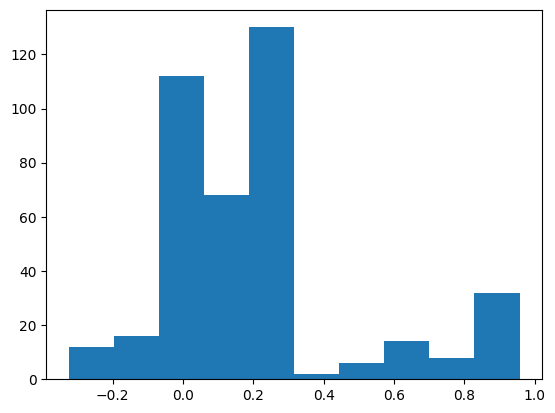

In [45]:
plt.hist(corr_dict_sorted.values())

Lets look at the top correlations:

In [89]:
list(zip(list(corr_dict_sorted.keys())[-1:-25:-1],list(corr_dict_sorted.values())[-1:-25:-1]))

[((9, 8), 0.9570330035266038),
 ((8, 9), 0.9570330035266038),
 ((13, 12), 0.9533876637026473),
 ((12, 13), 0.9533876637026473),
 ((12, 11), 0.9506111502999005),
 ((11, 12), 0.9506111502999005),
 ((11, 10), 0.9501370303346989),
 ((10, 11), 0.9501370303346989),
 ((10, 9), 0.9450097017865612),
 ((9, 10), 0.9450097017865612),
 ((12, 10), 0.91502119139515),
 ((10, 12), 0.91502119139515),
 ((13, 11), 0.9144297515618338),
 ((11, 13), 0.9144297515618338),
 ((10, 8), 0.9110353593896339),
 ((8, 10), 0.9110353593896339),
 ((11, 9), 0.910533471699806),
 ((9, 11), 0.910533471699806),
 ((13, 10), 0.8814258127122916),
 ((10, 13), 0.8814258127122916),
 ((12, 9), 0.8788280314158659),
 ((9, 12), 0.8788280314158659),
 ((11, 8), 0.8736256584264133),
 ((8, 11), 0.8736256584264133)]

Now lets do this separating by population:

In [48]:
c_df_0 = d1["Training"][(d1["Target"]==0).to_numpy()].corr()
c_df_1 = d1["Training"][(d1["Target"]==1).to_numpy()].corr()

/var/folders/zy/0rgyywr10tq2p0l5lkdf14v80000gq/T/ipykernel_39613/1597690493.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c_df_0 = d1["Training"][(d1["Target"]==0).to_numpy()].corr()
/var/folders/zy/0rgyywr10tq2p0l5lkdf14v80000gq/T/ipykernel_39613/1597690493.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c_df_1 = d1["Training"][(d1["Target"]==1).to_numpy()].corr()


We'll the steps above into a function so we don't have to copy and paste code:

In [92]:
def matrix_to_dict(c_matrix):
    c_matrix_0=c_df_0.to_numpy()
    corr_dict = OrderedDict()
    for i in range(c_matrix.shape[0]):
        for j in range(c_matrix.shape[0]):
            corr_dict[(i,j)]=c_matrix[i][j]
            
    corr_dict_sorted = OrderedDict(sorted(corr_dict.items(),
                                      key=lambda x: math.fabs(x[1])))
    return corr_dict_sorted       

In [93]:
corr_dict_sorted_0 = matrix_to_dict(c_df_0.to_numpy())
corr_dict_sorted_1 = matrix_to_dict(c_df_1.to_numpy())

Lets check of the top correlations are the same:

In [97]:
list(zip(zip(list(corr_dict_sorted_0.keys())[-1:-25:-1],list(corr_dict_sorted_0.values())[-1:-25:-1]),
         zip(list(corr_dict_sorted_1.keys())[-1:-25:-1],list(corr_dict_sorted_1.values())[-1:-25:-1])))

[(((13, 12), 0.9499147315177627), ((9, 8), 0.9738914942451165)),
 (((12, 13), 0.9499147315177627), ((8, 9), 0.9738914942451165)),
 (((12, 11), 0.9402603085150995), ((10, 9), 0.9629475051217274)),
 (((11, 12), 0.9402603085150995), ((9, 10), 0.9629475051217274)),
 (((9, 8), 0.9394324952085749), ((11, 10), 0.9617823737124946)),
 (((8, 9), 0.9394324952085749), ((10, 11), 0.9617823737124946)),
 (((11, 10), 0.9377481456048278), ((12, 11), 0.9604117680976006)),
 (((10, 11), 0.9377481456048278), ((11, 12), 0.9604117680976006)),
 (((10, 9), 0.925997638031567), ((13, 12), 0.9569341614653629)),
 (((9, 10), 0.925997638031567), ((12, 13), 0.9569341614653629)),
 (((13, 11), 0.903156873194596), ((11, 9), 0.935265073804128)),
 (((11, 13), 0.903156873194596), ((9, 11), 0.935265073804128)),
 (((12, 10), 0.9027414965497884), ((10, 8), 0.9351442009972297)),
 (((10, 12), 0.9027414965497884), ((8, 10), 0.9351442009972297)),
 (((10, 8), 0.8857972561576166), ((12, 10), 0.9266768008057209)),
 (((8, 10), 0.8857

It doesn't appear that there is correlations differences between the population.

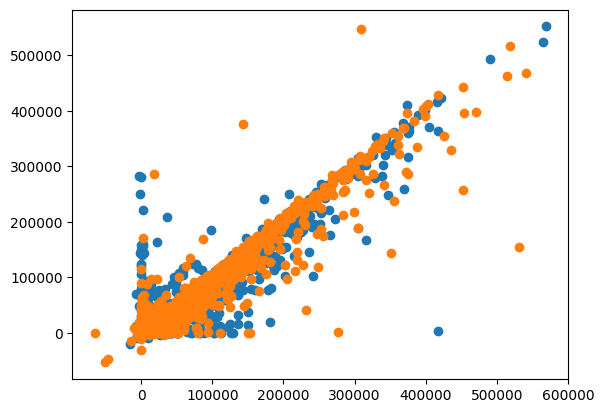

In [109]:
df_0 = d1["Training"][(d1["Target"]==0).to_numpy()]
df_1 = d1["Training"][(d1["Target"]==1).to_numpy()]

plt.scatter(df_0.iloc[:,12],df_0.iloc[:,13])
plt.scatter(df_1.iloc[:,12],df_1.iloc[:,13])

## Multiclass

Quick side... if we wanted to look into multiclass classification dataset, we would do the same things separately for each class (aka population). For regression, we can create populations by binning in the target value, for example low, medium, and high values.

Here's an example modification, we allows me to specify the populations more generically in a dictionary:

In [57]:
def compare_features_multiclass(d,selections,logscale=False):
    # Divide the data into separate dfs for the two categories
    
    dfs = dict()
    for name,selection in selections.items():
        dfs[name] = d["Training"][eval(selection).to_numpy()]
        print("Number of catogory 0:",dfs[name])
        
    # Make a grid of plots
    N_Features = d["Training"].shape[1]
    N_X= math.ceil(math.sqrt(N_Features))
    N_Y= math.floor(math.sqrt(N_Features))
    if N_X*N_Y<N_Features:
        N_Y+=1

    print("Found",N_Features,"features. Creating grid of",N_X,"by",N_Y)
    
    # Histogram Features
    plt.figure(figsize=(50,50))

    for i,column in enumerate(d["Training"].columns):
        #KS_test=scipy.stats.kstest(df_0[column],df_1[column]).statistic
        #print(column,"KS Distribution Similarity Test:", KS_test)
        
        plt.subplot(N_X,N_Y,i+1)
        #plt.title(str(KS_test))
        if logscale:
            plt.yscale("log")
        for name,selection in selections.items():
            plt.hist(dfs[name][column],bins=100, histtype="step",label=name,density=1, stacked=True)
        plt.legend()
        plt.xlabel(column)
        
    plt.show()

In [58]:
d2= load_dataset(multi_classification[10])

In [59]:
np.unique(d2["Target"])

array([3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Number of catogory 0:       Precinct Sector  Occurred_hour  Occurred_min
26765        0      5              0             0
46157        4      7              4             4
22874        1      0              0             0
30550        3      4              0             0
4143         2     14              0             0
...        ...    ...            ...           ...
27890        4     12              0             0
48033        4     12              0             0
26557        4     12             19            19
14541        4      9             22            22
19118        3     16             22            22

[1885 rows x 4 columns]
Number of catogory 0:       Precinct Sector  Occurred_hour  Occurred_min
8742         4      7              0             1
5953         1      6             22            22
29470        4      9              0             1
4022         1      8             20            20
11540        1      0              0             1
9373         

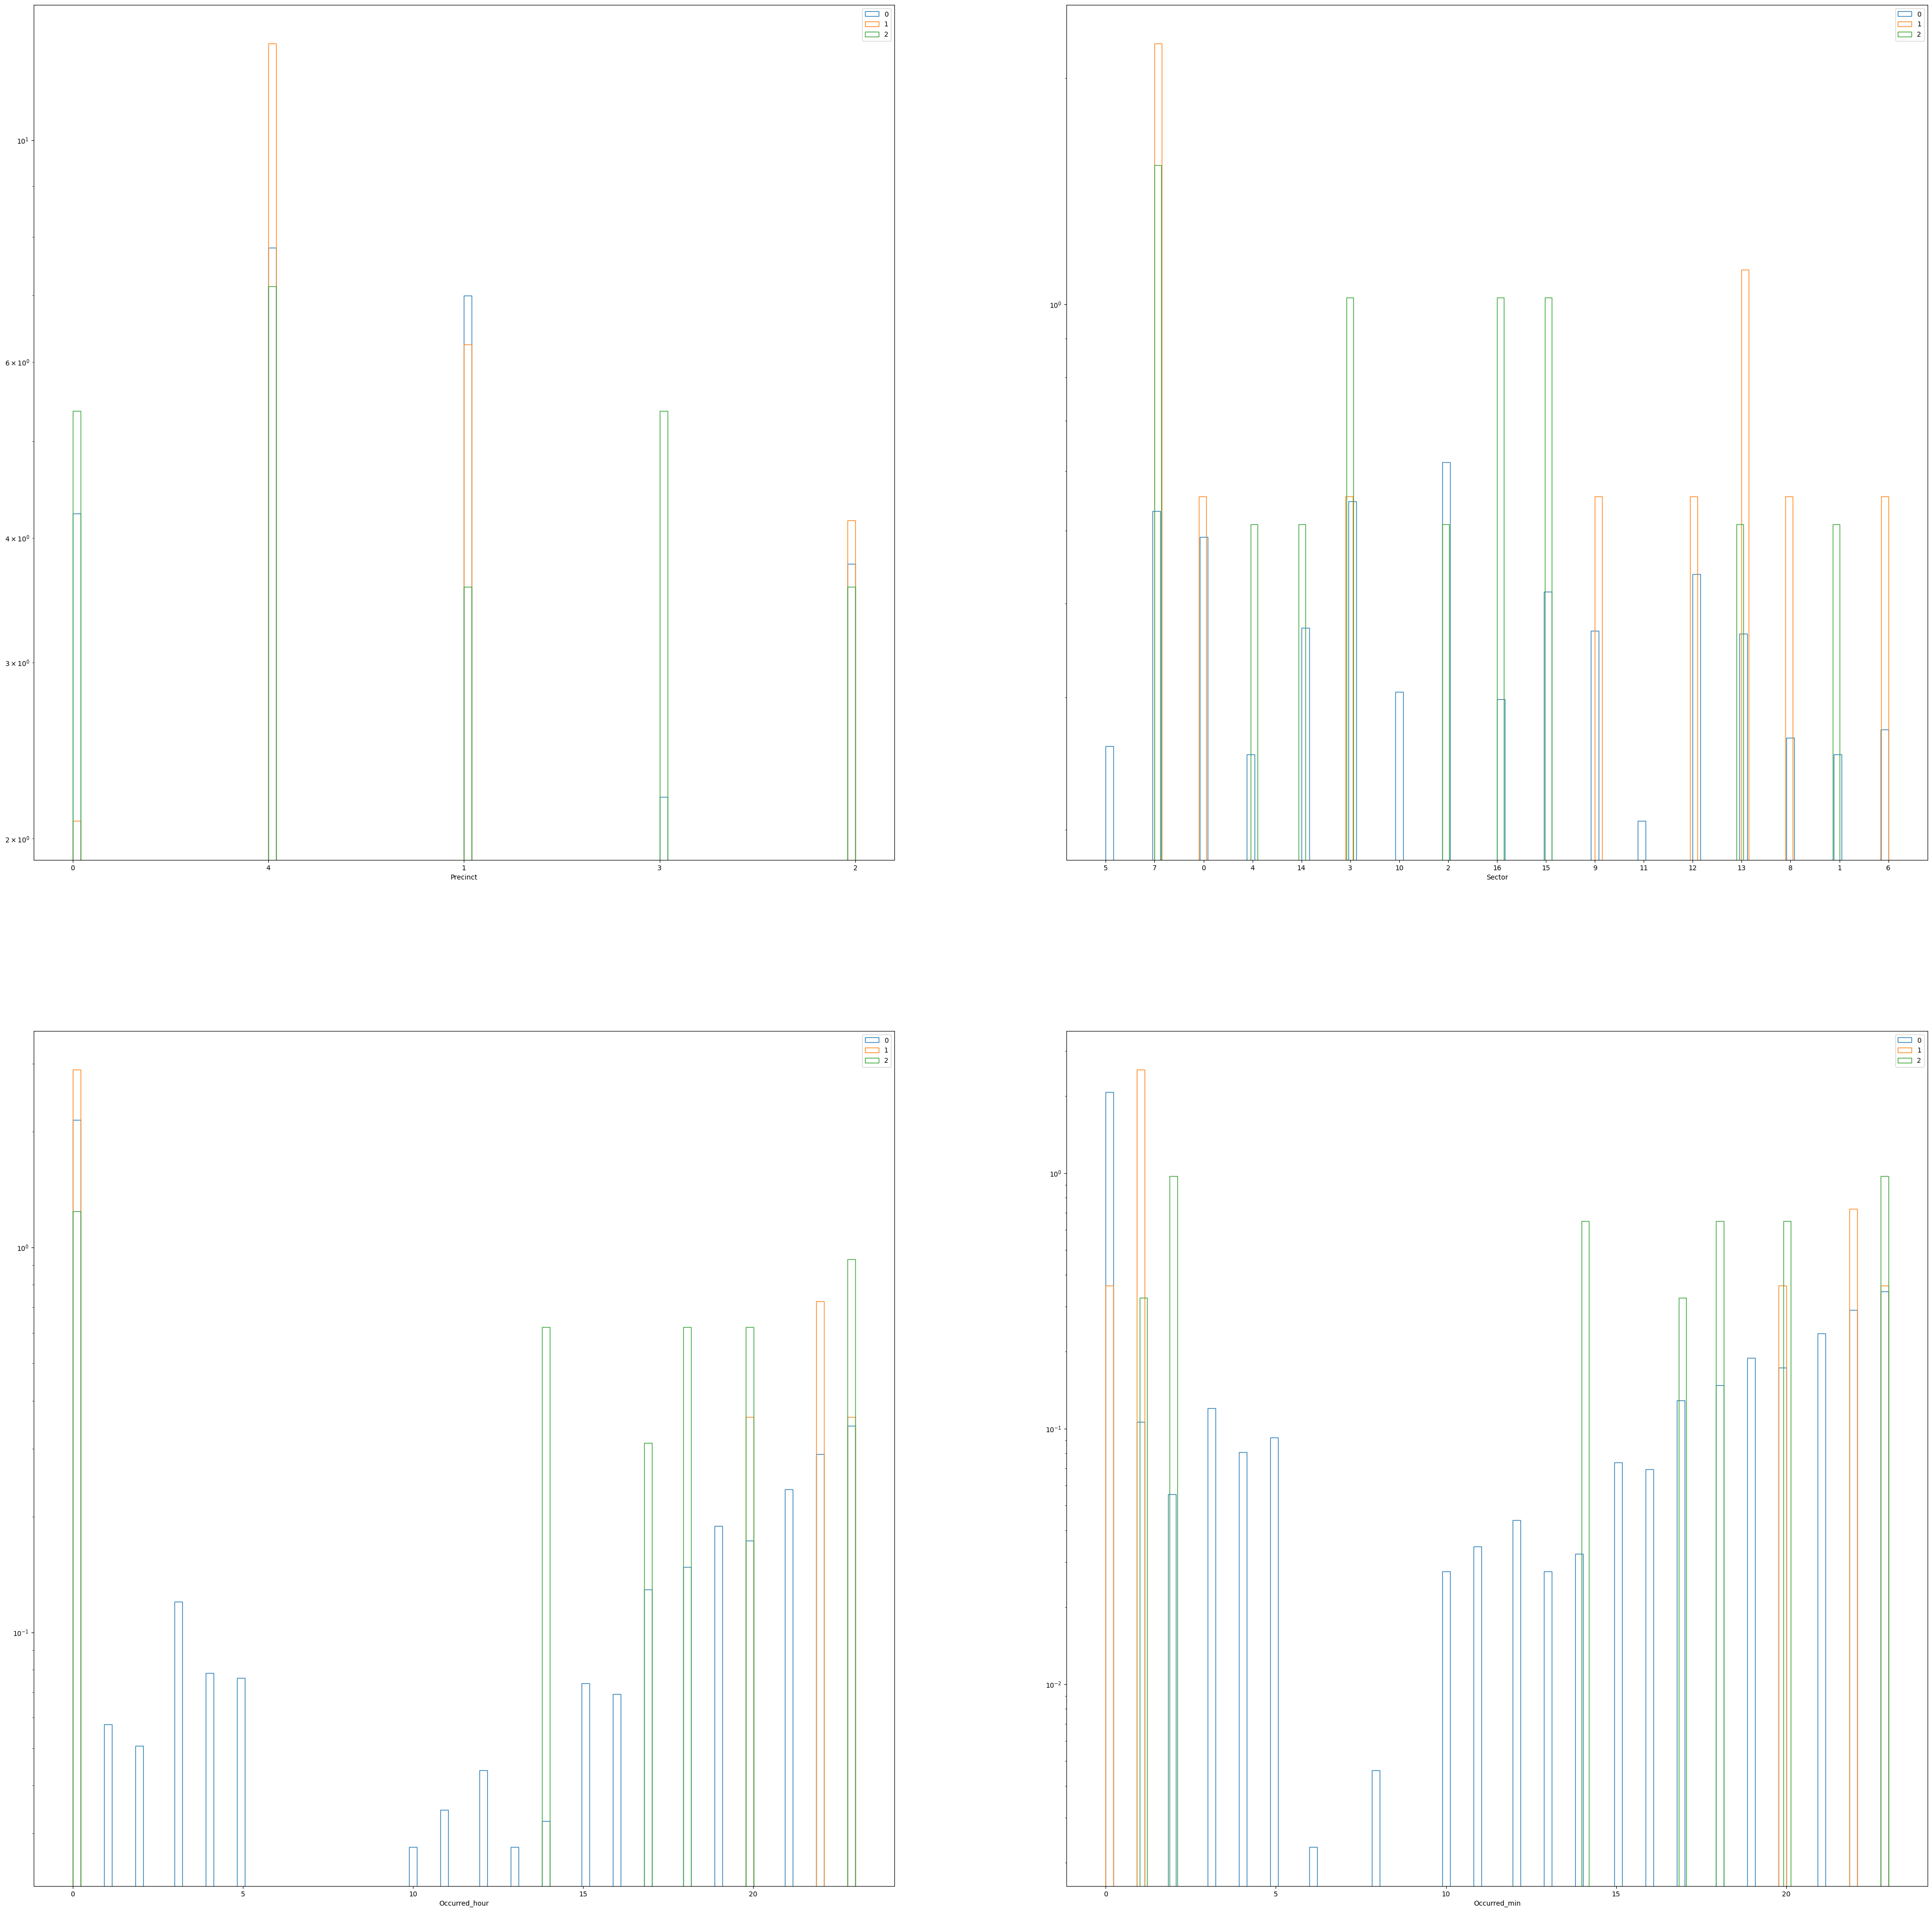

In [60]:
compare_features_multiclass(load_dataset(multi_classification[1]),
                        {"0":"d['Target']==0",
                        "1":"d['Target']==1",
                        "2":"d['Target']==2"
                        },
                        True)

## Categorical Variables

In [123]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [129]:
d1["Training"]["x2"]

7249     1
8814     0
2083     1
7735     0
10646    1
        ..
11964    1
5191     1
5390     0
860      1
7270     1
Name: x2, Length: 7963, dtype: category
Categories (2, object): ['0' < '1']

In [135]:
d1["Training"]

,x1,x2,x5,x6,x7,x8,x9,x10,x11,x12,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
7249,30000.0,1,22,0.0,0.0,0.0,2.0,0.0,0.0,27444.0,...,29886.0,28392.0,22612.0,22750.0,2000.0,1800.0,0.0,1000.0,1000.0,0.0
8814,50000.0,0,41,4.0,3.0,2.0,0.0,0.0,-1.0,52955.0,...,50307.0,27707.0,28479.0,28979.0,0.0,0.0,0.0,974.0,31100.0,1200.0
2083,310000.0,1,42,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-606.0,...,19950.0,79227.0,20097.0,25594.0,45484.0,20033.0,79520.0,94.0,25910.0,10933.0
7735,150000.0,0,56,2.0,0.0,0.0,0.0,0.0,0.0,116928.0,...,43045.0,40813.0,42164.0,43465.0,5006.0,3000.0,1452.0,5000.0,5000.0,2000.0
10646,120000.0,1,33,0.0,0.0,0.0,-1.0,-1.0,0.0,35563.0,...,19747.0,1201.0,2333.0,2250.0,1426.0,6400.0,1500.0,2700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,50000.0,1,50,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,50000.0,1,34,0.0,0.0,-1.0,-1.0,-1.0,-1.0,2435.0,...,197.0,2995.0,19515.0,0.0,0.0,197.0,2995.0,19515.0,0.0,3734.0
5390,10000.0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,9457.0,...,7335.0,9025.0,7886.0,8382.0,1107.0,1310.0,2000.0,269.0,1000.0,1100.0
860,50000.0,1,23,0.0,0.0,0.0,0.0,-1.0,0.0,48482.0,...,11151.0,-2897.0,48211.0,48154.0,2500.0,3002.0,1500.0,52000.0,1900.0,1800.0


In [136]:
cat_varnames=["x2","x5","x6","x7","x8","x9","x10","x11"]

In [137]:
[len(d1["Training"][x].unique()) for x in cat_varnames]

[2, 53, 11, 10, 11, 11, 10, 10]

In [149]:
d1["Training"][cat_varnames]

,x2,x5,x6,x7,x8,x9,x10,x11
7249,1,22,0.0,0.0,0.0,2.0,0.0,0.0
8814,0,41,4.0,3.0,2.0,0.0,0.0,-1.0
2083,1,42,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0
7735,0,56,2.0,0.0,0.0,0.0,0.0,0.0
10646,1,33,0.0,0.0,0.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...
11964,1,50,1.0,-2.0,-2.0,-2.0,-2.0,-2.0
5191,1,34,0.0,0.0,-1.0,-1.0,-1.0,-1.0
5390,0,27,0.0,0.0,0.0,0.0,0.0,0.0
860,1,23,0.0,0.0,0.0,0.0,-1.0,0.0


In [150]:
encoder=OneHotEncoder()
encoder.fit(d1["Training"][cat_varnames])

OneHotEncoder()

In [153]:
encoded = pd.DataFrame(encoder.transform(d1["Training"][cat_varnames]).toarray())

In [154]:
encoded

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7959,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7961,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalizing Data


In [112]:
d1["Training"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7963 entries, 7249 to 7270
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x1      7963 non-null   float64 
 1   x2      7963 non-null   category
 2   x5      7963 non-null   uint8   
 3   x6      7963 non-null   float64 
 4   x7      7963 non-null   float64 
 5   x8      7963 non-null   float64 
 6   x9      7963 non-null   float64 
 7   x10     7963 non-null   float64 
 8   x11     7963 non-null   float64 
 9   x12     7963 non-null   float64 
 10  x13     7963 non-null   float64 
 11  x14     7963 non-null   float64 
 12  x15     7963 non-null   float64 
 13  x16     7963 non-null   float64 
 14  x17     7963 non-null   float64 
 15  x18     7963 non-null   float64 
 16  x19     7963 non-null   float64 
 17  x20     7963 non-null   float64 
 18  x21     7963 non-null   float64 
 19  x22     7963 non-null   float64 
 20  x23     7963 non-null   float64 
dtypes: category

In [113]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [168]:
d1["Training"]=d1["Training_0"]  

In [169]:
d1["Training"].drop(columns=cat_varnames)

,x1,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
7249,30000.0,27444.0,29000.0,29886.0,28392.0,22612.0,22750.0,2000.0,1800.0,0.0,1000.0,1000.0,0.0
8814,50000.0,52955.0,51847.0,50307.0,27707.0,28479.0,28979.0,0.0,0.0,0.0,974.0,31100.0,1200.0
2083,310000.0,-606.0,44878.0,19950.0,79227.0,20097.0,25594.0,45484.0,20033.0,79520.0,94.0,25910.0,10933.0
7735,150000.0,116928.0,87215.0,43045.0,40813.0,42164.0,43465.0,5006.0,3000.0,1452.0,5000.0,5000.0,2000.0
10646,120000.0,35563.0,25614.0,19747.0,1201.0,2333.0,2250.0,1426.0,6400.0,1500.0,2700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,50000.0,2435.0,0.0,197.0,2995.0,19515.0,0.0,0.0,197.0,2995.0,19515.0,0.0,3734.0
5390,10000.0,9457.0,9554.0,7335.0,9025.0,7886.0,8382.0,1107.0,1310.0,2000.0,269.0,1000.0,1100.0
860,50000.0,48482.0,47226.0,11151.0,-2897.0,48211.0,48154.0,2500.0,3002.0,1500.0,52000.0,1900.0,1800.0


In [170]:
scaler_minmax = MinMaxScaler()
d1["Training"]=pd.DataFrame(scaler_minmax.fit_transform(d1["Training"]))

In [172]:
d1["Training"]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.027027,1.0,0.018519,0.2,0.222222,0.2,0.4,0.2,0.2,0.055603,...,0.118117,0.147523,0.125050,0.398961,0.006192,0.004489,0.000000,0.002314,0.002392,0.000000
1,0.054054,0.0,0.370370,0.6,0.555556,0.4,0.2,0.2,0.1,0.096687,...,0.149849,0.146443,0.134752,0.405820,0.000000,0.000000,0.000000,0.002254,0.074404,0.002270
2,0.405405,1.0,0.388889,0.0,0.000000,0.0,0.0,0.0,0.1,0.010429,...,0.102677,0.227679,0.120891,0.402093,0.140811,0.049957,0.190427,0.000218,0.061987,0.020680
3,0.189189,0.0,0.648148,0.4,0.222222,0.2,0.2,0.2,0.2,0.199713,...,0.138564,0.167108,0.157383,0.421769,0.015498,0.007481,0.003477,0.011571,0.011962,0.003783
4,0.148649,1.0,0.222222,0.2,0.222222,0.2,0.1,0.1,0.2,0.068678,...,0.102362,0.104648,0.091515,0.376390,0.004415,0.015960,0.003592,0.006248,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,0.054054,1.0,0.537037,0.3,0.000000,0.0,0.0,0.0,0.0,0.011405,...,0.071677,0.102754,0.087657,0.373913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7959,0.054054,1.0,0.240741,0.2,0.222222,0.1,0.1,0.1,0.1,0.015327,...,0.071983,0.107477,0.119929,0.373913,0.000000,0.000491,0.007172,0.045160,0.000000,0.007063
7960,0.000000,0.0,0.111111,0.2,0.222222,0.2,0.2,0.2,0.2,0.026635,...,0.083075,0.116985,0.100698,0.383142,0.003427,0.003267,0.004789,0.000622,0.002392,0.002081
7961,0.054054,1.0,0.037037,0.2,0.222222,0.2,0.2,0.1,0.2,0.089483,...,0.089004,0.098187,0.167383,0.426932,0.007740,0.007486,0.003592,0.120334,0.004546,0.003405


Number of catogory 0: 3977
Number of catogory 1: 3986
Found 21 features. Creating grid of 5 by 5
0 KS Distribution Similarity Test: 0.184
1 KS Distribution Similarity Test: 0.051
2 KS Distribution Similarity Test: 0.036
3 KS Distribution Similarity Test: 0.366
4 KS Distribution Similarity Test: 0.290
5 KS Distribution Similarity Test: 0.256
6 KS Distribution Similarity Test: 0.220
7 KS Distribution Similarity Test: 0.187
8 KS Distribution Similarity Test: 0.175
9 KS Distribution Similarity Test: 0.046
10 KS Distribution Similarity Test: 0.036
11 KS Distribution Similarity Test: 0.027
12 KS Distribution Similarity Test: 0.029
13 KS Distribution Similarity Test: 0.028
14 KS Distribution Similarity Test: 0.034
15 KS Distribution Similarity Test: 0.150
16 KS Distribution Similarity Test: 0.145
17 KS Distribution Similarity Test: 0.145
18 KS Distribution Similarity Test: 0.129
19 KS Distribution Similarity Test: 0.119
20 KS Distribution Similarity Test: 0.125


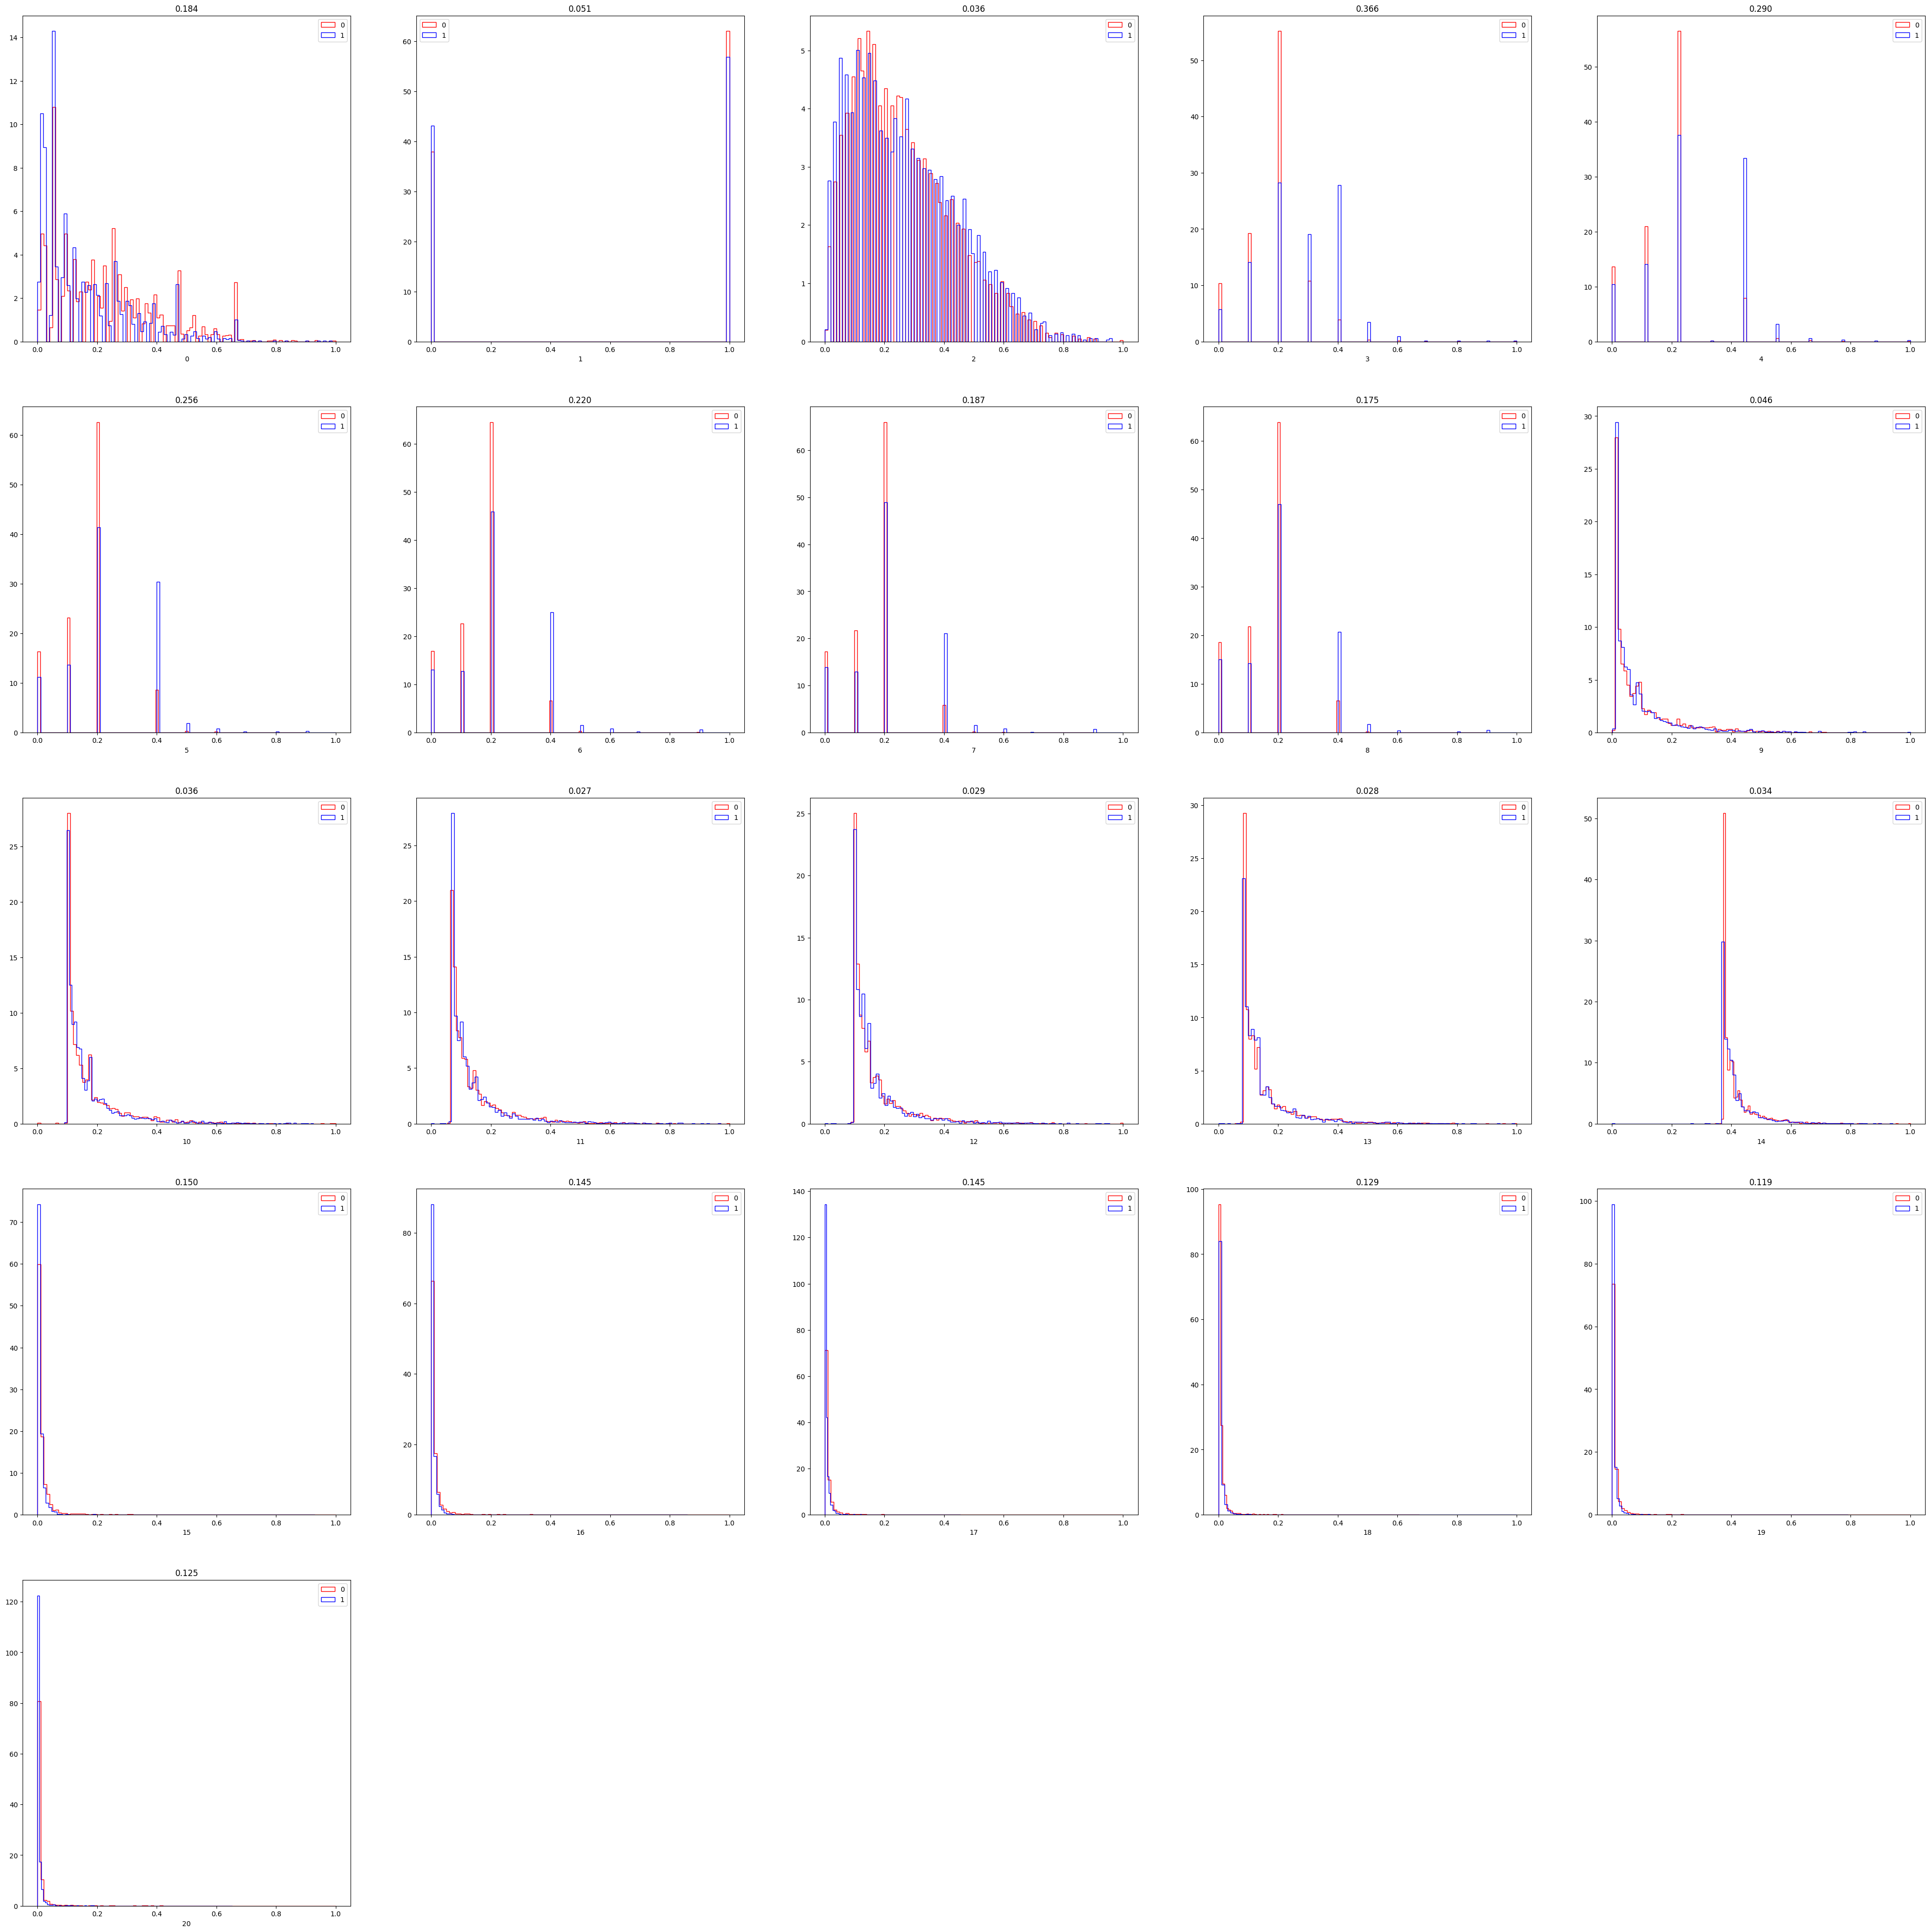

In [171]:
compare_features_binary(d1,logscale=False)

In [175]:
d1["Training"].shape

(7963, 21)

In [178]:
training_data = pd.concat([d1["Training"],encoded],axis=1)

In [179]:
d1["Training"]=training_data

In [188]:
d1["Training"]

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,0.027027,1.0,0.018519,0.2,0.222222,0.2,0.4,0.2,0.2,0.055603,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.054054,0.0,0.370370,0.6,0.555556,0.4,0.2,0.2,0.1,0.096687,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.405405,1.0,0.388889,0.0,0.000000,0.0,0.0,0.0,0.1,0.010429,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.189189,0.0,0.648148,0.4,0.222222,0.2,0.2,0.2,0.2,0.199713,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.148649,1.0,0.222222,0.2,0.222222,0.2,0.1,0.1,0.2,0.068678,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,0.054054,1.0,0.537037,0.3,0.000000,0.0,0.0,0.0,0.0,0.011405,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7959,0.054054,1.0,0.240741,0.2,0.222222,0.1,0.1,0.1,0.1,0.015327,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7960,0.000000,0.0,0.111111,0.2,0.222222,0.2,0.2,0.2,0.2,0.026635,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7961,0.054054,1.0,0.037037,0.2,0.222222,0.2,0.2,0.1,0.2,0.089483,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Trying ML Algorithm



In [180]:
d1["Training"].shape

(7963, 139)

In [181]:
import math

N_total = d1["Training"].shape[0]
N_train = math.floor(.8*N_total)
N_val = math.floor((N_total-N_train)/2.)
N_test = math.floor((N_total-N_train)/2.)

X_train = d1["Training"][:N_train]
Y_train = d1["Target"][:N_train]

X_val = d1["Training"][N_train:N_val+N_train]
Y_val = d1["Target"][N_train:N_val+N_train]
                     
X_test = d1["Training"][N_train+N_val:N_test+N_val+N_train]
Y_test = d1["Target"][N_train+N_val:N_test+N_val+N_train]

N_val

796

In [182]:
import sklearn.discriminant_analysis as DA
# Instanciate Method
Fisher=DA.LinearDiscriminantAnalysis()

In [183]:
Fisher.fit(X_train,Y_train)

/Users/afarbin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

In [184]:
Fisher.predict(X_val.to_numpy())

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [185]:
X_val_0 = X_val[Y_val.to_numpy()==0]
X_val_1 = X_val[Y_val.to_numpy()==1]

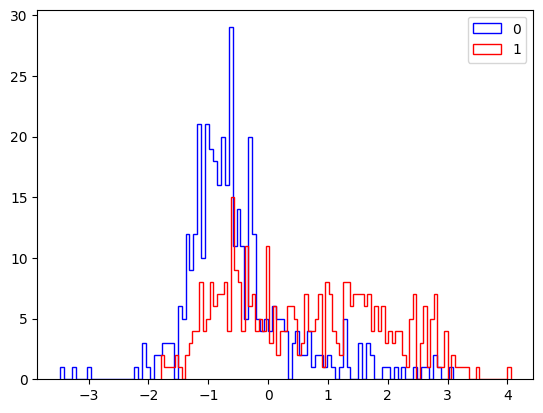

In [186]:
plt.figure()
plt.hist(Fisher.decision_function(X_val_0.to_numpy()),bins=100,histtype="step", color="blue", label="0",stacked=True)
plt.hist(Fisher.decision_function(X_val_1.to_numpy()),bins=100,histtype="step", color="red", label="1",stacked=True)
plt.legend(loc='upper right')
plt.show()

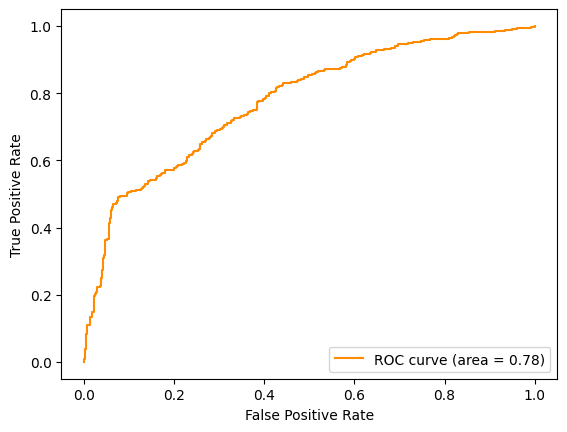

In [187]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test.to_numpy(), Fisher.decision_function(X_test.to_numpy()))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Comparing ML Algorithms

In [69]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



In [194]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
#     "Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Naive Bayes",
#     "QDA",
]
classifier_instances = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
#     GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
#     DecisionTreeClassifier(max_depth=5, random_state=42),
#     RandomForestClassifier(
#         max_depth=5, n_estimators=10, max_features=1, random_state=42
#     ),
#     MLPClassifier(alpha=1, max_iter=1000, random_state=42),
#     AdaBoostClassifier(algorithm="SAME", random_state=42),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
]
classifiers = dict(zip(names,classifier_instances))

In [195]:
datasets = { name : (d["Training"],d["Target"]) for name , d in [(name , load_dataset(name)) for name in binary_classification_datasets]}

In [196]:
classifiers.keys()

dict_keys(['Nearest Neighbors', 'Linear SVM', 'RBF SVM'])

In [197]:
#figure = plt.figure(figsize=(27, 9))
# iterate over datasets
import sys

def fit_all(datasets,classifiers, max_ds=None, max_cls=None):
    scores = dict()
    for ds_cnt, (ds_name,ds) in enumerate(datasets.items()):
        # preprocess dataset, split into training and test part
        X, y = ds
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )

        if max_ds:
            if ds_cnt>max_ds:
                print("Max Datasets Reached.")
                sys.stdout.flush()
                break
                
        scores[ds_name] = dict()
        # iterate over classifiers
        for cls_cnt,(cls_name, clf) in enumerate(classifiers.items()):
            print(ds_cnt,cls_cnt,"Running classifier",cls_name,"on dataset",ds_name,". N_Train = ",X_train.shape[0] )
            sys.stdout.flush()
            clf_0 = make_pipeline(StandardScaler(), clf)
            clf_0.fit(X_train.to_numpy(), y_train.to_numpy().reshape((len(y_train),)))
            score = clf.score(X_test.to_numpy(), y_test.to_numpy())

            scores[ds_name][cls_name] = score
            if max_cls:
                if cls_cnt>max_cls:
                    print("Max Classifiers Reached.")
                    sys.stdout.flush()
                    break


    return scores
        

#plt.tight_layout()
#plt.show()

In [198]:
scores = fit_all(datasets,classifiers,1,2)

0 0 Running classifier Nearest Neighbors on dataset 334_361283 . N_Train =  4777
0 1 Running classifier Linear SVM on dataset 334_361283 . N_Train =  4777
0 2 Running classifier RBF SVM on dataset 334_361283 . N_Train =  4777
1 0 Running classifier Nearest Neighbors on dataset 334_361282 . N_Train =  20970
1 1 Running classifier Linear SVM on dataset 334_361282 . N_Train =  20970
1 2 Running classifier RBF SVM on dataset 334_361282 . N_Train =  20970
Max Datasets Reached.


In [199]:
scores

{'334_361283': {'Nearest Neighbors': 0.5012554927809165,
  'Linear SVM': 0.5018832391713748,
  'RBF SVM': 0.4981167608286252},
 '334_361282': {'Nearest Neighbors': 0.5395179171733067,
  'Linear SVM': 0.5756383663543381,
  'RBF SVM': 0.4965310063657821}}

In [200]:
display(HTML(tabulate.tabulate(list(map(lambda x: [x[0]]+x[1],zip(scores.keys(),map(lambda x: list(x.values()),scores.values())))), 
                               tablefmt='html',
                               headers=[" "]+list(next(iter(scores.items()))[1].keys()))))

,Nearest Neighbors,Linear SVM,RBF SVM
334_361283,0.501255,0.501883,0.498117
334_361282,0.539518,0.575638,0.496531
